PyTorch version: 2.6.0+cu124
CUDA: True
Device name: NVIDIA A100-PCIE-40GB
[0.8360188  0.11314284 0.05083836]
{'attention': 0, "I'm": 1, 'implementing': 2, 'mechanism': 3, 'self': 4}

Input as tensor:
tensor([1, 2, 4, 0, 3])
Embedded sentence shape: (5, 6)
[[0.75677423 0.09200861 0.25739907 0.87367706 0.61332087 0.61984356]
 [0.05637278 0.37199973 0.33892665 0.54728987 0.31098627 0.16896011]
 [0.89291965 0.0904551  0.22211467 0.17663937 0.01543062 0.27606963]
 [0.77094477 0.32219199 0.56414769 0.57782391 0.90321731 0.87463244]
 [0.05811804 0.25007908 0.03687517 0.2399311  0.29981932 0.30253411]]

=== Original Embeddings ===
[[0.7568 0.092  0.2574 0.8737 0.6133 0.6198]
 [0.0564 0.372  0.3389 0.5473 0.311  0.169 ]
 [0.8929 0.0905 0.2221 0.1766 0.0154 0.2761]
 [0.7709 0.3222 0.5641 0.5778 0.9032 0.8746]
 [0.0581 0.2501 0.0369 0.2399 0.2998 0.3025]]

=== Positional Encoding Added the final input for the transformer encoder===
[[ 0.7568  1.092   0.2574  1.8737  0.6133  1.6198]
 [ 0.8979  0.

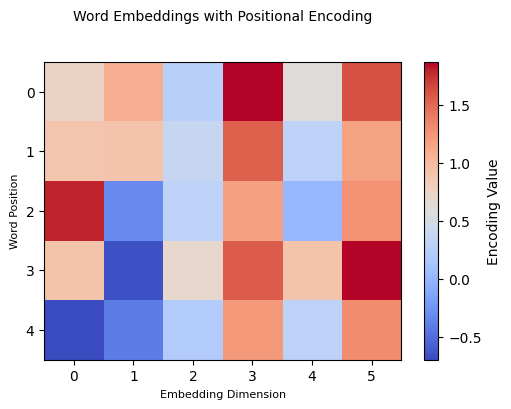

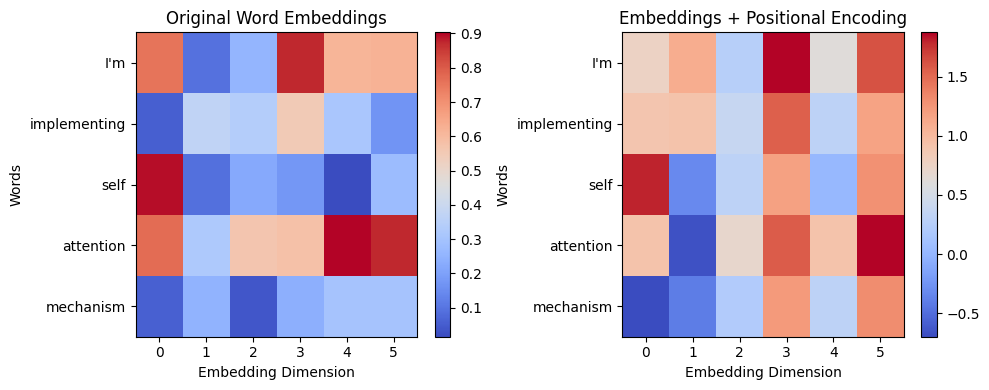

torch.Size([5, 3])
tensor([[2.5574, 1.9673, 1.3909],
        [2.2849, 1.7690, 1.3144],
        [2.2804, 1.7660, 1.3123],
        [2.6369, 2.0305, 1.4020],
        [2.0898, 1.6330, 1.2429]], grad_fn=<MmBackward0>)


In [1]:
# get everything that is present in previous notebook
%run self_attention.ipynb

In [2]:
# implementing multi-head attention
'''so In simple, why we need multi-head attention, because to get more better semantic meaning of our input.
The idea is that, we split our embedding into multiple heads, means our weight matrices of query, key, value
will be seprated into smaller pieces, and then perform attention for each and then concatenate them'''

class Multi_headAttention(nn.Module):
    def __init__(self, d_model, num_head, d_k=None, d_v=None):
        super(Multi_headAttention, self).__init__()
        assert d_model % num_head == 0 # embedding size must be divisible by no. of head
        self.num_head = num_head
        self.head_dim = d_model // num_head

        # if d_k and d_v not specified then use head_dim
        self.d_k= d_k if d_k else self.head_dim
        self.d_v= d_v if d_v else self.head_dim

        self.w_query = nn.Parameter(torch.rand(d_model, num_head*self.d_k))
        self.w_key = nn.Parameter(torch.rand(d_model, num_head*self.d_k))
        self.w_value = nn.Parameter(torch.rand(d_model, num_head*self.d_v))

        #output projection
        self.w_out = nn.Parameter(torch.rand(num_head*self.d_v, d_model))

    def forward(self, x):
        if isinstance(x, np.ndarray): # convert np array to torch tensor
            x = torch.tensor(x, dtype=torch.float32)

        sequence_length = x.shape[0]

        #linear projection
        Q = x @ self.w_query
        K = x @ self.w_key
        V = x @ self.w_value

        # splitting the projection into chunks for each head 
        Q = Q.view(sequence_length, self.num_head, self.d_k).transpose(0,1)
        K = K.view(sequence_length, self.num_head, self.d_k).transpose(0,1)
        V = V.view(sequence_length, self.num_head, self.d_v).transpose(0,1)

        # dot product
        attention_score = Q @ K.transpose(-2,-1) / math.sqrt(self.d_k)
        attention_weights = F.softmax(attention_score, dim=-1)
        context = attention_weights @ V

        # concatenate all the heads
        output = context.transpose(0,1).contiguous().view(sequence_length, -1) @ self.w_out

        return output

In [3]:
mha = Multi_headAttention(d_model=6, num_head=2)

# Pass in your embedding_sentence (same as before)
output = mha(embedding_sentence)

# Print shape and values
print("Output shape:", output.shape)
print("Output tensor:\n", output)

Output shape: torch.Size([5, 6])
Output tensor:
 tensor([[8.9520, 6.1403, 6.3872, 7.1573, 7.2711, 8.0402],
        [7.8695, 5.3919, 5.6358, 6.2704, 6.3907, 7.0582],
        [7.9576, 5.4224, 5.6797, 6.3617, 6.4884, 7.1429],
        [9.1966, 6.3142, 6.5579, 7.3552, 7.4589, 8.2586],
        [7.2018, 4.9065, 5.1567, 5.7383, 5.8568, 6.4517]],
       grad_fn=<MmBackward0>)


### Cross Attention 
- it is an mechanism with multi-head attention, layer normalization and residual connection. This is widely used in decoder block layer where queries as input comes from decoder, key and values as input comes from encoder block.

In [10]:
class CrossAttention(nn.Module):
    def __init__(self, d_model, num_head, dropout=0.1, d_k=None,d_v=None):
        super(CrossAttention, self).__init__()
        assert d_model % num_head ==0

        self.d_model = d_model
        self.num_head = num_head
        self.head_dim = d_model // num_head # head dimmension

        # use head_dim if d_k, and d_v is not defined
        self.d_k = d_k if d_k else self.head_dim
        self.d_v = d_v if d_v else self.head_dim

        self.w_query = nn.Linear(d_model, num_head*self.d_k, bias=False)
        self.w_key = nn.Linear(d_model, num_head*self.d_k, bias=False)
        self.w_value = nn.Linear(d_model, num_head*self.d_v, bias=False)

        # output projection
        self.w_out = nn.Linear(num_head*self.d_v, d_model, bias=False)

        self.dropout = nn.Dropout(dropout)

        # layer normalisation
        self.layer_norm = nn.LayerNorm(d_model)

        # initilaise the weight 
        self._init_weights()

    def _init_weights(self):
        for module in [self.w_query, self.w_key, self.w_value, self.w_out]:
            nn.init.xavier_uniform_(module.weight)

    def forward(self, query, key, value, mask=None):
        residual = query
        batch_size = query.size(0)

        Q = self.w_query(query)
        K = self.w_key(key)
        V = self.w_value(value)

        # reshaping 
        Q = Q.view(batch_size, -1, self.num_head, self.d_k).transpose(1,2)
        K = K.view(batch_size, -1, self.num_head, self.d_k).transpose(1,2)
        V = V.view(batch_size, -1, self.num_head, self.d_v).transpose(1,2)

        attention_score = torch.matmul(Q, K.transpose(-2,-1))/math.sqrt(self.d_k)

        # applying padding
        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0, -1e9)

        attention_weights = F.softmax(attention_score, dim =-1)
        attention_weights = self.dropout(attention_weights)

        # get context vector
        context = torch.matmul(attention_weights, V)

        context = context.transpose(1,2).contiguous().view(batch_size, -1, self.num_head * self.d_v)

        output = self.w_out(context)

        output = self.layer_norm(residual + output)

        return output

In [ ]:
'''
Why padding mask ?

The main concern was to use this as not all sentences are of same length, so adding padding tokens will bring all the sentences to have same length, and creating mask so that
our softmax function shouldn't consider these uniformative tokens.
Note, it's very important to notice while in this section, the padding mask is likely to be composed by two masks, one for the Query and other for the Key. 
'''

#define specs for testing
batch_size=2
d_model =512
num_heads=8
encoder_length = 10
decoder_length_target = 7

decoder_input = torch.rand(batch_size, decoder_length_target, d_model)
encoder_input = torch.rand(batch_size, encoder_length, d_model)

# create padding mask
padding_mask = torch.ones(batch_size, encoder_length)
padding_mask[0, -2:]=0
padding_mask[1, -3:]=0
new_padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)

print(f"Decoder Input - query shape :{decoder_input}")
print(f"Encoder Input - key, value shape :{encoder_input}")
print(f"padding mask :{padding_mask.int()}")
print(f"Padding mask shape :{padding_mask.shape}")

cross_attention_layer = CrossAttention(d_model=d_model, num_head=num_heads)

output = cross_attention_layer(query=decoder_input, key=encoder_input, value=encoder_input,mask=new_padding_mask)

print(f"Final output shape:{output.shape}")


Decoder Input - query shape :tensor([[[0.1467, 0.1123, 0.3424,  ..., 0.8767, 0.4380, 0.2612],
         [0.8462, 0.0268, 0.4870,  ..., 0.7005, 0.1709, 0.9944],
         [0.9250, 0.9954, 0.2186,  ..., 0.2225, 0.5267, 0.5358],
         ...,
         [0.7182, 0.5737, 0.0994,  ..., 0.4119, 0.4354, 0.6899],
         [0.9655, 0.4201, 0.5093,  ..., 0.3546, 0.6501, 0.1051],
         [0.1996, 0.1609, 0.8638,  ..., 0.8052, 0.4325, 0.7170]],

        [[0.2901, 0.8909, 0.3852,  ..., 0.9051, 0.0259, 0.6753],
         [0.2857, 0.2778, 0.8856,  ..., 0.7323, 0.6971, 0.7571],
         [0.3366, 0.6759, 0.2777,  ..., 0.0943, 0.7353, 0.9855],
         ...,
         [0.5640, 0.0953, 0.3867,  ..., 0.2941, 0.1855, 0.9820],
         [0.0558, 0.1559, 0.0189,  ..., 0.3003, 0.0994, 0.1048],
         [0.6800, 0.7077, 0.9065,  ..., 0.4173, 0.7954, 0.1199]]])
Encoder Input - key, value shape :tensor([[[0.4070, 0.9644, 0.3401,  ..., 0.6079, 0.1194, 0.0997],
         [0.8970, 0.5488, 0.9351,  ..., 0.0238, 0.5300, 0.72